In [1]:
import numpy as np
#np.set_printoptions(threshold = np.nan, linewidth = 115)
import pickle

# Load with pickle instead of processing images again
training_img_1 = pickle.load(open('1vAll_img_res_Infiltration_1st_half.p', 'rb'))
training_img_2 = pickle.load(open('1vAll_img_res_Infiltration_2nd_half.p', 'rb'))

In [2]:
training_img_one = np.append(training_img_1, training_img_2, axis=0)

In [3]:
training_img_3 = pickle.load(open('1vAll_img_res_Infiltration_3rd_half.p', 'rb'))
training_img_4 = pickle.load(open('1vAll_img_res_Infiltration_4th_half.p', 'rb'))

In [4]:
training_img_two = np.append(training_img_3, training_img_4, axis=0)

In [5]:
training_img = np.append(training_img_one, training_img_two, axis=0)

training_img.shape

(36298, 256, 256, 1)

In [6]:
labels_1 = pickle.load(open('1vAll_labels_res_Infiltration_1st_half.p', 'rb'))
labels_2 = pickle.load(open('1vAll_labels_res_Infiltration_2nd_half.p', 'rb'))
labels_3 = pickle.load(open('1vAll_labels_res_Infiltration_3rd_half.p', 'rb'))
labels_4 = pickle.load(open('1vAll_labels_res_Infiltration_4th_half.p', 'rb'))

In [7]:
training_labels = np.append(labels_1, np.append(labels_2, np.append(labels_3, labels_4, axis = 0), axis = 0), axis = 0)

In [8]:
test_img = pickle.load(open('1vAll_test_img.p', 'rb'))
test_labels = pickle.load(open('1vAll_test_labels.p', 'rb'))

print('Labels shape: ', training_labels.shape)
print('Length of test_labels: ', len(test_labels))
print('No. of Infiltration Diagnoses: ', sum(training_labels))

Labels shape:  (36298,)
Length of test_labels:  3490
No. of Infiltration Diagnoses:  18149


In [9]:
import keras
from keras import models, optimizers, layers, regularizers, metrics, losses
from keras.layers.advanced_activations import LeakyReLU, PReLU, ELU, ReLU, ThresholdedReLU
from keras.layers.core import Dense, Dropout, SpatialDropout2D, Activation
from keras.layers.convolutional import Conv2D, SeparableConv2D
from keras.models import model_from_json, Sequential

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config = config)

import matplotlib.pyplot as plt

IMG_SIZE = 256

# Save Comparison model
def save_model(model_name, hist_str, model_str):

    pickle.dump(model_name.history, open('Training Histories/'+ hist_str + '.p', 'wb'))
    
    print("Saved " + hist_str + " to Training Histories folder")
    
    # serialize model to JSON
    model_name = model.to_json()
    with open("CNN Models/" + model_str + ".json", "w") as json_file:
        json_file.write(model_name)

    # serialize weights to HDF5
    model.save_weights("CNN Models/" + model_str + ".h5")
    print("Saved " + model_str + " and weights to CNN Models folder")
    
# Load model architecture and weights NOTE: must compile again
def load_model():
    model_str = str(input("Name of model to load: "))

    # load json and create model
    json_file = open('CNN Models/' + model_str + '.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("CNN Models/" + model_str + ".h5")
    print("Loaded " + model_str + " and weights from CNN Models folder")
    
    return loaded_model
    
# Load history object
def load_history():
    hist_str = str(input("Name of history to load: "))

    loaded_history = pickle.load(open('Training Histories/' + hist_str + '.p', 'rb'))
    
    print("Loaded " + hist_str + " from Training Histories folder")
    
    return loaded_history

Infiltration_class_weight = [{0: 1, 1: 12.938}]

### Custom Loss function
#from keras import backend as K

#def LSEP(true_label, pred_label):
#    return K.log(1 + K.sum(K.exp(true_label - pred_label)))


from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                         normalize = False,
                         title = 'Confusion Matrix',
                         cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print("Confusion Matrix without Normalization")
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45) 
    plt.yticks(tick_marks, classes)
    #print(cm)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment = 'center',
                color='white' if cm[i, j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')

# Metric Analysis
def _1vAll_accuracy(y_test, pred):
    
    pred = np.squeeze(pred, axis = -1)
    pred = np.round_(pred)
    pred = pred.astype(dtype = 'uint8')
    
    ft = pred == y_test
    
    accuracy = sum(ft)/len(ft)
        
    print('\t Complete Label Accuracy: %.2f' % round((accuracy * 100), 2), '%')
    
    print('Sum of Fully Correct Predictions: ', sum(ft))
    print('\t\t    Total Labels: ', len(ft))
    
    return accuracy

Using TensorFlow backend.


### One Vs. All

In [ ]:
# Infiltration One Vs. All

model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.005), input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(SpatialDropout2D(0.25))
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
model.add(layers.Dense(1, activation='sigmoid'))

Name of model to load: Infiltration_1vAll_50e
Loaded Infiltration_1vAll_50e and weights from CNN Models folder
Train on 31760 samples, validate on 4538 samples
Epoch 51/100
 - 167s - loss: 0.6610 - acc: 0.6226 - val_loss: 0.7785 - val_acc: 0.4628
Epoch 52/100
 - 39s - loss: 0.6610 - acc: 0.6222 - val_loss: 0.8256 - val_acc: 0.4024
Epoch 53/100
 - 39s - loss: 0.6611 - acc: 0.6233 - val_loss: 0.9157 - val_acc: 0.3316
Epoch 54/100
 - 39s - loss: 0.6605 - acc: 0.6231 - val_loss: 0.8028 - val_acc: 0.4465
Epoch 55/100
 - 39s - loss: 0.6610 - acc: 0.6214 - val_loss: 0.7715 - val_acc: 0.4277
Epoch 56/100
 - 39s - loss: 0.6616 - acc: 0.6215 - val_loss: 0.7674 - val_acc: 0.4762
Epoch 57/100
 - 39s - loss: 0.6606 - acc: 0.6253 - val_loss: 0.7938 - val_acc: 0.4429
Epoch 58/100
 - 39s - loss: 0.6612 - acc: 0.6216 - val_loss: 0.7729 - val_acc: 0.4277
Epoch 59/100
 - 39s - loss: 0.6610 - acc: 0.6233 - val_loss: 0.9231 - val_acc: 0.3361
Epoch 60/100
 - 39s - loss: 0.6615 - acc: 0.6223 - val_loss: 0.75

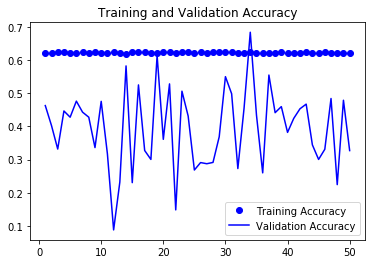

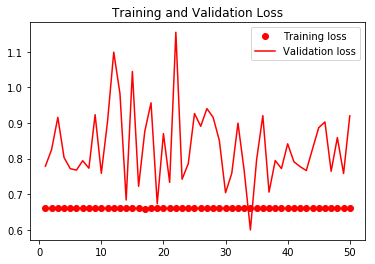

Normalized Confusion Matrix


<Figure size 432x288 with 0 Axes>

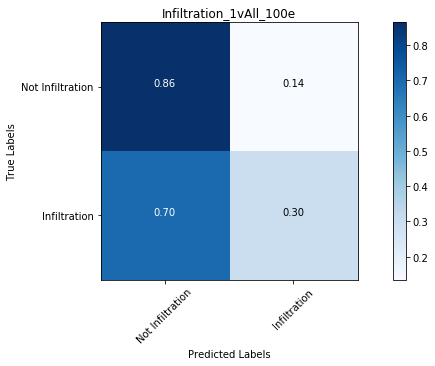

In [16]:
# Last model: Infiltration_1vAll_50e
model = load_model()
#model.summary()

model.compile(optimizer = optimizers.RMSprop(lr = 1e-3), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

model_obj = model.fit(training_img, training_labels, 
                      epochs = 100, initial_epoch = 50, 
                      validation_split = (1 / 8), 
                      batch_size = 64, verbose = 2 )

Predictions = model.predict(test_img)

Accuracy = _1vAll_accuracy(test_labels, Predictions)

history_str = 'Infiltration_1vAll_100e_history'
model_str   = 'Infiltration_1vAll_100e'
    
save_model(model_obj, history_str, model_str)

acc = model_obj.history['acc']
val_acc = model_obj.history['val_acc']
loss = model_obj.history['loss']
val_loss = model_obj.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot Confusion Matrix
cm = confusion_matrix(test_labels, np.round_(Predictions))
cm_plot_labels = ['Not Infiltration', 'Infiltration']

plt.clf()
fig = plt.figure(figsize = (10, 5))
plot_confusion_matrix(cm, cm_plot_labels, title = model_str, normalize=True)
#save_plt(fig)

Train on 31760 samples, validate on 4538 samples
Epoch 1/50
 - 347s - loss: 5.2881 - acc: 0.5714 - val_loss: 1.9701 - val_acc: 0.0000e+00
Epoch 2/50
 - 38s - loss: 1.8361 - acc: 0.5714 - val_loss: 2.0146 - val_acc: 0.0000e+00
Epoch 3/50
 - 37s - loss: 1.8155 - acc: 0.5714 - val_loss: 1.9479 - val_acc: 0.0000e+00
Epoch 4/50
 - 37s - loss: 1.8047 - acc: 0.5714 - val_loss: 1.9452 - val_acc: 0.0000e+00
Epoch 5/50
 - 37s - loss: 1.7968 - acc: 0.5714 - val_loss: 1.9685 - val_acc: 0.0000e+00
Epoch 6/50
 - 37s - loss: 1.7899 - acc: 0.5714 - val_loss: 1.9613 - val_acc: 0.0000e+00
Epoch 7/50
 - 37s - loss: 1.7787 - acc: 0.5714 - val_loss: 1.9565 - val_acc: 0.0000e+00
Epoch 8/50
 - 37s - loss: 1.7763 - acc: 0.5714 - val_loss: 1.9511 - val_acc: 0.0000e+00
Epoch 9/50
 - 38s - loss: 1.7794 - acc: 0.5714 - val_loss: 1.9633 - val_acc: 0.0000e+00
Epoch 10/50
 - 37s - loss: 1.7832 - acc: 0.5714 - val_loss: 1.9714 - val_acc: 0.0000e+00
Epoch 11/50
 - 37s - loss: 1.7857 - acc: 0.5714 - val_loss: 1.9509 - 

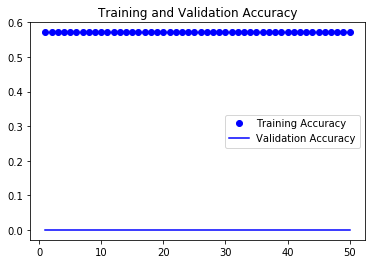

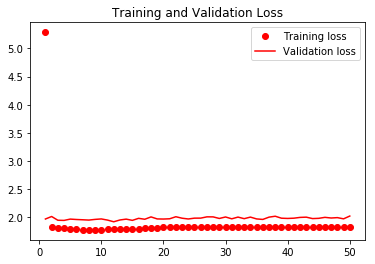

Normalized Confusion Matrix


<Figure size 432x288 with 0 Axes>

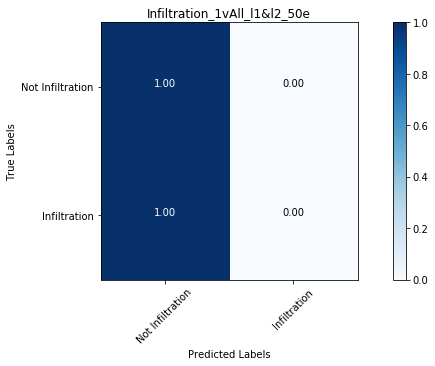

In [12]:
# Infiltration One Vs. All - L1 & L2 Regularizers

model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.005), input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(SpatialDropout2D(0.25))
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.005)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.005)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.005)))
model.add(layers.Dense(1, activation='sigmoid'))

# Last model: Infiltration_1vAll_l1&l2_50e
#model = load_model()
#model.summary()

model.compile(optimizer = optimizers.Adam(), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

model_obj = model.fit(training_img, training_labels, 
                      epochs = 50, initial_epoch = 0, 
                      validation_split = (1 / 8), 
                      batch_size = 128, verbose = 2 )

Predictions = model.predict(test_img)

Accuracy = _1vAll_accuracy(test_labels, Predictions)

history_str = 'Infiltration_1vAll_l1&l2_50e_history'
model_str   = 'Infiltration_1vAll_l1&l2_50e'
    
save_model(model_obj, history_str, model_str)

acc = model_obj.history['acc']
val_acc = model_obj.history['val_acc']
loss = model_obj.history['loss']
val_loss = model_obj.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot Confusion Matrix
cm = confusion_matrix(test_labels, np.round_(Predictions))
cm_plot_labels = ['Not Infiltration', 'Infiltration']

plt.clf()
fig = plt.figure(figsize = (10, 5))
plot_confusion_matrix(cm, cm_plot_labels, title = model_str, normalize=True)
#save_plt(fig)

In [ ]:
# Infiltration One Vs. All - Nesterov Adam Optimizer

model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.005), input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(SpatialDropout2D(0.25))
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.005)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.005)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.005)))
model.add(layers.Dense(1, activation='sigmoid'))

Name of model to load: 1vAll_Nadam_50e
Loaded 1vAll_Nadam_50e and weights from CNN Models folder


Exception ignored in: <bound method TF_Output.<lambda> of <tensorflow.python.pywrap_tensorflow_internal.TF_Output; proxy of <Swig Object of type 'TF_Output *' at 0x00000266BBBAFF00> >>
Traceback (most recent call last):
  File "c:\users\rocke\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\pywrap_tensorflow_internal.py", line 864, in <lambda>
    __del__ = lambda self: None
KeyboardInterrupt


Train on 31760 samples, validate on 4538 samples
Epoch 1/50
 - 149s - loss: 11.4982 - acc: 0.5714 - val_loss: 14.0496 - val_acc: 0.0000e+00
Epoch 2/50
 - 39s - loss: 10.9369 - acc: 0.5714 - val_loss: 9.2409 - val_acc: 0.0000e+00
Epoch 3/50
 - 39s - loss: 10.6274 - acc: 0.5714 - val_loss: 11.6584 - val_acc: 0.0000e+00
Epoch 4/50
 - 39s - loss: 10.3415 - acc: 0.5714 - val_loss: 9.7472 - val_acc: 0.0000e+00
Epoch 5/50
 - 39s - loss: 10.0632 - acc: 0.5714 - val_loss: 10.4624 - val_acc: 0.0000e+00
Epoch 6/50
 - 39s - loss: 9.7994 - acc: 0.5714 - val_loss: 9.6194 - val_acc: 0.0000e+00
Epoch 7/50
 - 39s - loss: 9.5446 - acc: 0.5714 - val_loss: 9.7000 - val_acc: 0.0000e+00
Epoch 8/50
 - 40s - loss: 9.3013 - acc: 0.5714 - val_loss: 9.2760 - val_acc: 0.0000e+00
Epoch 9/50
 - 40s - loss: 9.0670 - acc: 0.5714 - val_loss: 9.1780 - val_acc: 0.0000e+00
Epoch 10/50
 - 39s - loss: 8.8425 - acc: 0.5714 - val_loss: 8.8556 - val_acc: 0.0000e+00
Epoch 11/50
 - 39s - loss: 8.6268 - acc: 0.5714 - val_loss: 8

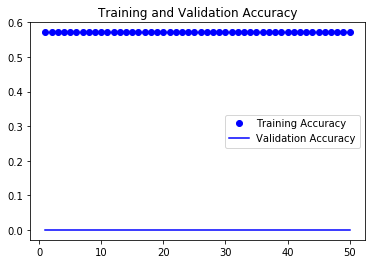

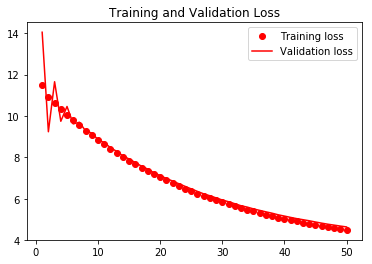

Normalized Confusion Matrix


<Figure size 432x288 with 0 Axes>

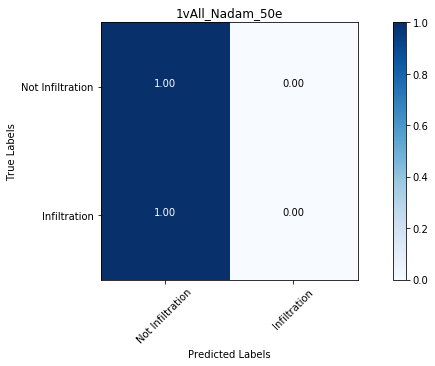

In [15]:
# Last model: 1vAll_Nadam_50e
model = load_model()
#model.summary()

model.compile(optimizer = optimizers.Nadam(), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

model_obj = model.fit(training_img, training_labels, 
                      epochs = 50, initial_epoch = 0, 
                      validation_split = (1 / 8), 
                      batch_size = 128, verbose = 2 )

Predictions = model.predict(test_img)

Accuracy = _1vAll_accuracy(test_labels, Predictions)

history_str = '1vAll_Nadam_50e_history'
model_str   = '1vAll_Nadam_50e'
    
save_model(model_obj, history_str, model_str)

acc = model_obj.history['acc']
val_acc = model_obj.history['val_acc']
loss = model_obj.history['loss']
val_loss = model_obj.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot Confusion Matrix
cm = confusion_matrix(test_labels, np.round_(Predictions))
cm_plot_labels = ['Not Infiltration', 'Infiltration']

plt.clf()
fig = plt.figure(figsize = (10, 5))
plot_confusion_matrix(cm, cm_plot_labels, title = model_str, normalize=True)
#save_plt(fig)

In [14]:
# Infiltration One Vs. All - Recurrent Neural Network

model = models.Sequential()
model.add(layers.SimpleRNN(16, (3, 3), activation='relu', 
                           kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.005), 
                           input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(SpatialDropout2D(0.25))
model.add(layers.SimpleRNN(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.005)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.SimpleRNN(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.005)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.005)))
model.add(layers.Dense(1, activation='sigmoid'))

# Last model: 1vAll_SimpleRNN_50e
#model = load_model()
#model.summary()

model.compile(optimizer = optimizers.Adam(), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

model_obj = model.fit(training_img, training_labels, 
                      epochs = 50, initial_epoch = 0, 
                      validation_split = (1 / 8), 
                      batch_size = 64, verbose = 2 )

Predictions = model.predict(test_img)

Accuracy = _1vAll_accuracy(test_labels, Predictions)

history_str = '1vAll_SimpleRNN_50e_history'
model_str   = '1vAll_SimpleRNN_50e'
    
save_model(model_obj, history_str, model_str)

acc = model_obj.history['acc']
val_acc = model_obj.history['val_acc']
loss = model_obj.history['loss']
val_loss = model_obj.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot Confusion Matrix
cm = confusion_matrix(test_labels, np.round_(Predictions))
cm_plot_labels = ['Not Infiltration', 'Infiltration']

plt.clf()
fig = plt.figure(figsize = (10, 5))
plot_confusion_matrix(cm, cm_plot_labels, title = model_str, normalize=True)
#save_plt(fig)

ValueError: Input 0 is incompatible with layer simple_rnn_1: expected ndim=3, found ndim=4